# Amazon Books Reviews Classifier (ABRC)
**University of Pavia**

*Natural Language Processing*

**Michele Ventimiglia**
**Giovanni Michele Miranda**

---

# Setup


We install the required libraries:

In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


We import all the libraires, classes and methods:

In [2]:
import os
import re
import sys
import torch
import string
import platform
import numpy as np
import seaborn as sns
from os import chdir
from torch import cuda
from scipy import stats
from pandas import read_csv
from torch.optim import Adam
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler as RUS
from torch.nn import Embedding, LSTM, Dropout, Linear, CrossEntropyLoss, Module

We display OS, Python, and PyTorch information:

In [ ]:
print(f">> OS: {platform.system()} {platform.release()}")
print(f">> Python: {sys.version}")
print(f">> Torch: {torch.__version__}")

>> OS: Windows 10
>> Python: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
>> Torch: 2.1.0.dev20230728+cu121


---

# Initialization

We initialize the PyTorch device:

In [ ]:
if not cuda.is_available():
    print(">> Unavaible!")
    device = "cpu"
else:
    print(">> CUDA avaible!")
    try:
        if not cuda.is_initialized():
            cuda.init()
        print(">> CUDA initialized!")
        try:
            cuda.empty_cache()
            print(">> CUDA cache cleared!")
            device = torch.device("cuda:0")
        except Exception as e:
            print(e)
    except Exception as e:
        raise(e)
if device != "cpu":
    print(f">> Device: GPU({device})")
elif device == "cpu":
    print(f">> Device: CPU")

>> CUDA avaible!
>> CUDA initialized!
>> CUDA cache cleared!
>> Device: GPU(cuda:0)


Mount personal Drive:

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
%cd "/content/gdrive/My Drive/michele.ventimiglia01@universitadipavia.com/Text Mining and Natural Lenguage Processing/Exam"

We set and display the current working directory:

In [ ]:
try:
    cwd = os.getcwd()
    print(f">> cwd: \"{cwd}\"")
except Exception as e:
    raise(e)
chdir(cwd)

>> cwd: "c:\Users\mikiv\Documents\GitHub\Private\Python\Artificial Intelligence\Sentiment Analysis"


---

# Data Analysis

We load the dataset from [here](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews):

In [ ]:
dataset = read_csv('data/Books_rating.csv')

We explore the dataset columns:

In [ ]:
print(list(dataset.columns))

['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness', 'review/score', 'review/time', 'review/summary', 'review/text']


We drop the rows that has empty train or target features:

In [ ]:
dataset.dropna(subset=['review/text', 'review/score'], inplace=True)

We select the target feature and the train column:

In [ ]:
ratings = np.reshape(np.array(dataset['review/score']), (-1, 1))
reviews = np.reshape(np.array(dataset['review/text']), (-1, 1))
print(f">> Ratings shape: {ratings.shape}")
print(f">> Reviews shape: {reviews.shape}")

>> Ratings shape: (2999992, 1)
>> Reviews shape: (2999992, 1)


We display the occurrence of rating values:

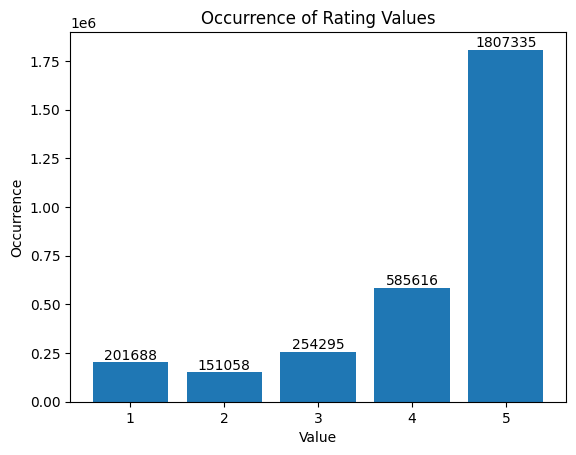

In [ ]:
unique_values, value_counts = np.unique(
    ratings,
    return_counts = True
)

plt.bar(unique_values, value_counts)
plt.xlabel('Value')
plt.ylabel('Occurrence')
plt.title('Occurrence of Rating Values')

for x, y in zip(unique_values, value_counts):
    plt.text(
        x, y, str(y),
        ha = 'center',
        va = 'bottom',
        fontsize = 10
    )

plt.show()

---

# Preprocessing

We balance the classes undersampling all of them to a user defined records number:

In [ ]:
#reviews_per_class = min(value_counts)
reviews_per_class = 1000  # Reduced because of Colab resources limits
under_sampler = RUS(
    sampling_strategy = {1: reviews_per_class,
                         2: reviews_per_class,
                         3: reviews_per_class,
                         4: reviews_per_class,
                         5: reviews_per_class},
    random_state = 101
)
resampled_reviews, resampled_ratings = under_sampler.fit_resample(reviews, ratings)
print(f">> Resampled ratings shape: {resampled_ratings.shape}")
print(f">> Resampled reviews shape: {resampled_reviews.shape}")

>> Resampled ratings shape: (755290,)
>> Resampled reviews shape: (755290, 1)


We load the english vocabolary from [here](https://github.com/dwyl/english-words.git):

In [ ]:
with open("data/words.txt", "r") as file:
    text = file.read()
english_vocabolary = set()
for word in text.replace('\n', ' ').split():
    english_vocabolary.add(word.lower())
print(f">> English vocabolary total words: {len(english_vocabolary)}")

>> English vocabolary total words: 466546


We get the tokenized words from each reviews, we filter the vocabolary to obtain only english words and reduce model complexity and computing time:

In [ ]:
vocabolary = set()
tokenized_reviews = []
for review in resampled_reviews:
    review = str(review[0])
    review = review.replace('\n', ' ').lower()
    review = re.sub('['+string.punctuation+']', ' ', review)
    words = review.split()
    new_words = []
    for word in words:
        if word in english_vocabolary:
            new_words.append(word)
    tokenized_reviews.append(new_words)
    vocabolary.update(new_words)
vocabolary = sorted(list(vocabolary))
num_words = len(vocabolary)
print(f">> Vocabolary total words: {num_words}")
print(f">> Vocabolary: {vocabolary}")

>> Vocabolary total words: 120310
>> Vocabolary: ['1080', '10th', '1st', '2', '2d', '2nd', '3d', '3m', '3rd', '4gl', '4h', '4th', '5th', '6th', '7th', '8th', '9th', 'a', 'a1', 'a4', 'a5', 'aa', 'aaa', 'aaaa', 'aaaaaa', 'aaas', 'aachen', 'aaf', 'aag', 'aah', 'aahed', 'aahing', 'aahs', 'aal', 'aalto', 'aam', 'aandahl', 'aao', 'aap', 'aar', 'aarau', 'aardvark', 'aardvarks', 'aardwolves', 'aargau', 'aargh', 'aarhus', 'aaron', 'aaronic', 'aaronite', 'aaronson', 'aarp', 'aarrgh', 'aas', 'aau', 'aaup', 'aauw', 'aax', 'ab', 'aba', 'ababa', 'abaci', 'aback', 'abaco', 'abacus', 'abacuses', 'abad', 'abadan', 'abaddon', 'abagail', 'abailard', 'abakan', 'abalone', 'aband', 'abandon', 'abandonable', 'abandoned', 'abandonee', 'abandoners', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abas', 'abase', 'abased', 'abasement', 'abases', 'abashed', 'abashedly', 'abashing', 'abashment', 'abasing', 'abate', 'abated', 'abatement', 'abatements', 'abates', 'abating', 'abatis', 'abaton', 'abattoir',

We adopt index mapping for words for the reviews:

In [ ]:
encoding_vocabolary = {}
encoding_vocabolary[''] = 1
for index, word in enumerate(vocabolary):
    encoding_vocabolary[word] = index + 2
decoding_vocabolary = {}
for word, index in encoding_vocabolary.items():
    decoding_vocabolary[index] = word
print(f">> Encoding vocabolary: {encoding_vocabolary}")
print(f">> Decoding vocabolary: {decoding_vocabolary}")

>> Encoding vocabolary: {'': 1, '1080': 2, '10th': 3, '1st': 4, '2': 5, '2d': 6, '2nd': 7, '3d': 8, '3m': 9, '3rd': 10, '4gl': 11, '4h': 12, '4th': 13, '5th': 14, '6th': 15, '7th': 16, '8th': 17, '9th': 18, 'a': 19, 'a1': 20, 'a4': 21, 'a5': 22, 'aa': 23, 'aaa': 24, 'aaaa': 25, 'aaaaaa': 26, 'aaas': 27, 'aachen': 28, 'aaf': 29, 'aag': 30, 'aah': 31, 'aahed': 32, 'aahing': 33, 'aahs': 34, 'aal': 35, 'aalto': 36, 'aam': 37, 'aandahl': 38, 'aao': 39, 'aap': 40, 'aar': 41, 'aarau': 42, 'aardvark': 43, 'aardvarks': 44, 'aardwolves': 45, 'aargau': 46, 'aargh': 47, 'aarhus': 48, 'aaron': 49, 'aaronic': 50, 'aaronite': 51, 'aaronson': 52, 'aarp': 53, 'aarrgh': 54, 'aas': 55, 'aau': 56, 'aaup': 57, 'aauw': 58, 'aax': 59, 'ab': 60, 'aba': 61, 'ababa': 62, 'abaci': 63, 'aback': 64, 'abaco': 65, 'abacus': 66, 'abacuses': 67, 'abad': 68, 'abadan': 69, 'abaddon': 70, 'abagail': 71, 'abailard': 72, 'abakan': 73, 'abalone': 74, 'aband': 75, 'abandon': 76, 'abandonable': 77, 'abandoned': 78, 'abandonee

Once obtained the vocabolaries we create the encoder class:

In [ ]:
class Enconder:
    def __init__(self, encoding_vocabolary: set, decoding_vocabolary: set) -> None:
        self.dec_voc = decoding_vocabolary
        self.enc_voc = encoding_vocabolary
    def encode(self, review: str) -> list:
        vector_review = []
        for word in review:
            vector_review.append(self.enc_voc[word])
        return vector_review
    def decode(self, review_indices: list) -> str:
        review_words = []
        for index in review_indices:
            word = self.dec_voc[index]
            review_words.append(word)
        return ' '.join(review_words)

We encode the tokenized reviews:

In [ ]:
encoder = Enconder(encoding_vocabolary, decoding_vocabolary)
X = []
for review in tokenized_reviews:
    X.append(encoder.encode(review))

We make and example of original, encoded and decoded review:

In [ ]:
print(f">> Original review: {resampled_reviews[0]}")
print(f">> Encoded review: {X[0]}")
decoded_review = encoder.decode(X[0])
print(f">> Decoded review: {decoded_review}")

>> Original review: ["After considering Thomas Harris' earlier works as exceptional entertainment, I found I had an exceptionally difficult time even getting through this book. One wonders if the same person wrote it as the writing styles seemed to change throughout -- sometime in the normal third person and sometimes as the all-knowing narrator -- making the book extremely difficult to read. Probably the biggest disappointment was in how the author chose to end this novel. After giving us exceptionally strong characters in &quot;Silence of the Lambs&quot;, these same characters rolled over and died without a fight(sometimes literally) in the sequel. If Thomas Harris was seeking contraversy, he hit the mark. If he was seeking a quality novel, he went off course about a third of the way through. Bottom line: don't waste your time."]
>> Encoded review: [1784, 22195, 106786, 47271, 32599, 118950, 5952, 36460, 34877, 51024, 40894, 51024, 46369, 3567, 36462, 29010, 107322, 36206, 43423, 106

We study and find a confidence interval for the reviews lengths distribution:

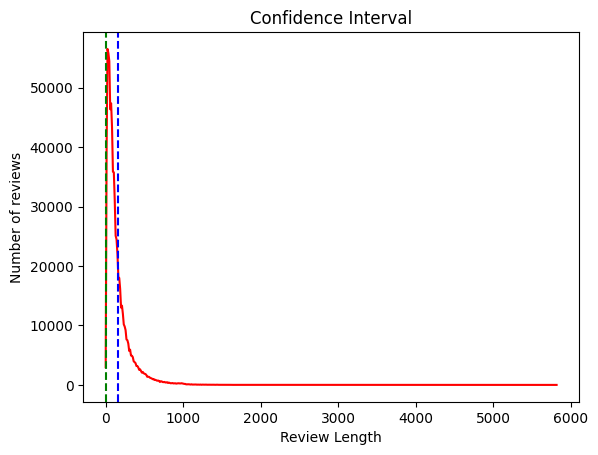

>> 68.46% (517106) of the reviews have lengths between the interval: [4, 161]


In [ ]:
## We get the list of all the lengths of all the reviews
review_lengths = []
for review in X:
    review_lengths.append(len(review))

## We get the mode of the lengths
mode = stats.mode(review_lengths, keepdims=True)[0][0]

## We compute the most dense interval of the reviews length
percentile_range = 50
lower_percentile = (100 - percentile_range) / 2
upper_percentile = 100 - lower_percentile
expand_range = np.percentile(review_lengths, upper_percentile, keepdims=True) - np.percentile(review_lengths, lower_percentile, keepdims=True)
conf_interval_min = mode - expand_range

## Not negative length condition
if conf_interval_min < 4:
    conf_interval_min = [4]

## We get the confidence interval
con_interval_max = mode + expand_range
indices = np.where((review_lengths >= conf_interval_min) and (review_lengths <= con_interval_max))[0]
conf_interval = np.array(review_lengths)[indices]

## We get the boundary of the interval
input_min=int(conf_interval_min[0])
input_max=int(con_interval_max[0])

## We get the percentage of the reviews in that interval
reviews_percentage = "{:.2f}".format(len(conf_interval)/len(X)*100)

## We plot the reviews lengths and the dense interval boundaries
hist, bins, _ = plt.hist(
    review_lengths,
    bins  = 500,
    color = 'red'
)

plt.close()
plt_x = bins[:-1]
plt_y = hist

plt.plot(
    plt_x, plt_y,
    color = 'red'
)

plt.axvline(
    conf_interval_min[0],
    color     = 'green',
    linestyle = '--'
)

plt.axvline(
    con_interval_max[0],
    color     = 'blue',
    linestyle = '--'
)

plt.ylabel("Number of reviews")
plt.xlabel("Review Length")
plt.title("Confidence Interval")
plt.show()

print(f">> {reviews_percentage}% ({len(conf_interval)}) of the reviews have lengths between the interval: [{int(conf_interval_min[0])}, {int(con_interval_max[0])}]")

We remove reviews longer based on the interval in order to avoid problem with too much filled empty values when padding sequences:

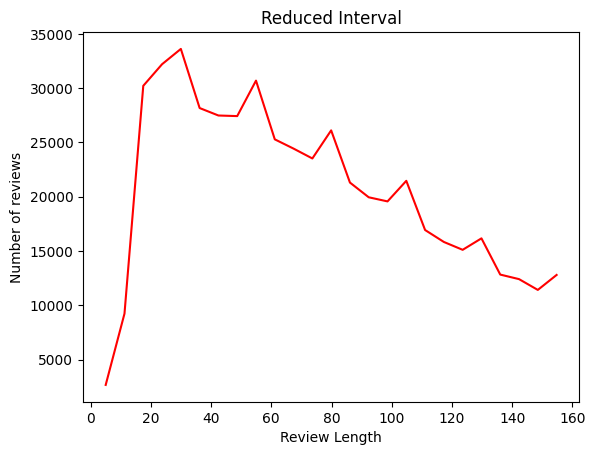

In [ ]:
X_reduced = []
y_reduced = []

for index in range(0, len(X)):
    if len(X[index]) <= input_max and len(X[index]) > input_min:
        X_reduced.append(X[index])
        y_reduced.append(resampled_ratings[index])

new_review_lengths = []
for review in X_reduced:
    new_review_lengths.append(len(review))

histogram, bins, _ = plt.hist(
    new_review_lengths,
    bins  = 25,
    color = 'red'
)

plt.close()
plt_x = bins[:-1]
plt_y = histogram

plt.plot(
    plt_x, plt_y,
    color = 'red'
)

plt.ylabel("Number of reviews")
plt.xlabel("Review Length")
plt.title("Reduced Interval")
plt.show()

We reshape the dataset and use padding to fill shorter reviews with values in order to have the same dimensionality:

In [ ]:
X_shaped = X_reduced
for val in range(len(X_reduced)):
    X_shaped[val] = torch.tensor(X_reduced[val], dtype=torch.int64)

## Transform X in a numpy array and fill shorter reviews to match shape
X_shaped = pad_sequence(
    X_reduced,
    batch_first = False,  # add value after the original ones
    padding_value = 1  # added value
)

X_shaped = X_shaped.view(-1, X_shaped.shape[0]).to(device, dtype=torch.int64)
print(f">> Reviews shape: ({X_shaped.shape[0]}, {X_shaped.shape[1]})")

>> Reviews shape: (516775, 161)


We reshape the labels:

In [ ]:
## Transform y in a numpy array with the correct shape
y_shaped = torch.tensor(np.reshape(y_reduced, (-1,1)) -1).to(device, dtype=torch.int64)
print(f">> Ratings shape: ({y_shaped.shape[0]}, {y_shaped.shape[1]})")

>> Ratings shape: (516775, 1)


We get train, test e validation sets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_shaped, y_shaped, test_size=0.2, random_state=101)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
print(f">> X_train shape : ({X_train.shape[0]}, {X_train.shape[1]})", end =" ")
print(f"- y_train shape : ({y_train.shape[0]}, {y_train.shape[1]})")
print(f">> X_test shape : ({X_test.shape[0]}, {X_test.shape[1]})", end =" ")
print(f"- y_test shape : ({y_test.shape[0]}, {y_test.shape[1]})")
print(f">> X_val shape : ({X_val.shape[0]}, {X_val.shape[1]})", end =" ")
print(f"- y_val shape : ({y_val.shape[0]}, {y_val.shape[1]})")

>> X_train shape : (330736, 161) - y_train shape : (330736, 1)
>> X_test shape : (103355, 161) - y_test shape : (103355, 1)
>> X_val shape : (82684, 161) - y_val shape : (82684, 1)


---

# Model

We build the PyTorch model:

In [ ]:
class Model(Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, dropout_rate):
        super().__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dr1 = Dropout(dropout_rate)
        self.fc1 = Linear(hidden_dim*2, hidden_dim)
        self.dr2 = Dropout(dropout_rate)
        self.fc2 = Linear(hidden_dim, num_classes)

    def forward(self, x):
        output = self.embedding(x)
        output, _ = self.lstm(output)
        output, _ = torch.max(output, dim=1)
        output = F.leaky_relu(self.fc1(output))
        output = F.leaky_relu(self.fc2(output))
        return output

We set the hyperparameters:

In [ ]:
vocab_size = len(decoding_vocabolary)+1
num_classes = len(unique_values)
embedding_dim = 256
hidden_dim = 64
dropout_rate = 0.5
learning_rate = 10**-4
epochs = 100
batch_size = 64

We compile the model

In [ ]:
model = Model(vocab_size, embedding_dim, hidden_dim, num_classes, dropout_rate).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = learning_rate)
lr_scheduler = LinearLR(optimizer, verbose=True)

Adjusting learning rate of group 0 to 3.3333e-05.


---

# Train

We create a class for data loading:

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

We load the datasets:

In [ ]:
train_dataset = TextDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = TextDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)
val_dataset = TextDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True)

We create a class for early stopping:

In [ ]:
class EarlyStopping:
    def __init__(self, patience: int = 5, delta: float = 0.0) -> None:
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_param = np.inf

    def __call__(self, parameter: float, epoch: int, model: torch.nn.Module, verbose: bool = True) -> bool:
        if parameter < (self.best_param + self.delta):
            self.best_param = parameter
            self.best_epoch = epoch
            self.best_model = model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"[!] Early stopping: no improvement [{self.counter}/{self.patience}]")
                return True
            if verbose: print(f"[!] Early stopping: no improvement [{self.counter}/{self.patience}]")
        return False

    def restore(self, verbose: bool = True) -> (torch.nn.Module, dict):
        if verbose: print(f"[!] Early stopping: restored best model from epoch {self.best_epoch+1}.")
        return self.best_model, self.best_epoch

We train the dataset:

In [ ]:
history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}
early_stopping = EarlyStopping(delta=0.001)

for epoch in range(epochs):
    correct = 0
    total = 0
    total_loss = 0
    model.train()

    for i, (inputs, labels) in enumerate(train_loader):
        labels = labels.view(-1)

        optimizer.zero_grad()

        ## Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        ## Compute the loss and perform backpropagation
        loss = criterion(outputs, labels)
        loss.backward()

        ## Gradient clipping to avoid exploding gradients
        clip_grad_norm_(model.parameters(), 0.5)

        optimizer.step()

        total_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_accuracy = correct / total
        average_train_loss = total_loss / len(train_loader)

        if (i+1) % batch_size == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}] - Loss: {average_train_loss:.4f}, Accuracy: {train_accuracy:.4f}', end='\r')

    history["loss"].append(average_train_loss)
    history["accuracy"].append(train_accuracy)

    # Validation phase
    model.eval()  # Set the model in evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            labels = labels.view(-1)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_accuracy = correct / total

    average_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {average_train_loss:.4f}, Accuracy: {train_accuracy:.4f} - Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    history["val_loss"].append(average_val_loss)
    history["val_accuracy"].append(val_accuracy)

    ## Check Early Stopping condition
    if early_stopping(average_val_loss, epoch, model):
        ## Restore the best model
        model, best_epoch = early_stopping.restore()
        break

    ## Update the learning rate
    lr_scheduler.step()

Epoch [1/100] - Loss: 0.5423, Accuracy: 0.8055 - Validation Loss: 0.3417, Validation Accuracy: 0.8571
Adjusting learning rate of group 0 to 4.6667e-05.
Epoch [2/100] - Loss: 0.3206, Accuracy: 0.8625 - Validation Loss: 0.3100, Validation Accuracy: 0.8656
Adjusting learning rate of group 0 to 6.0000e-05.
Epoch [3/100] - Loss: 0.3003, Accuracy: 0.8694 - Validation Loss: 0.2980, Validation Accuracy: 0.8688
Adjusting learning rate of group 0 to 7.3333e-05.
Epoch [4/100] - Loss: 0.2871, Accuracy: 0.8747 - Validation Loss: 0.2932, Validation Accuracy: 0.8704
Adjusting learning rate of group 0 to 8.6667e-05.
Epoch [5/100] - Loss: 0.2764, Accuracy: 0.8790 - Validation Loss: 0.2933, Validation Accuracy: 0.8708
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [6/100] - Loss: 0.2655, Accuracy: 0.8842 - Validation Loss: 0.2886, Validation Accuracy: 0.8737
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch [7/100] - Loss: 0.2540, Accuracy: 0.8896 - Validation Loss: 0.2873, Validation Acc

---

# Evaluation

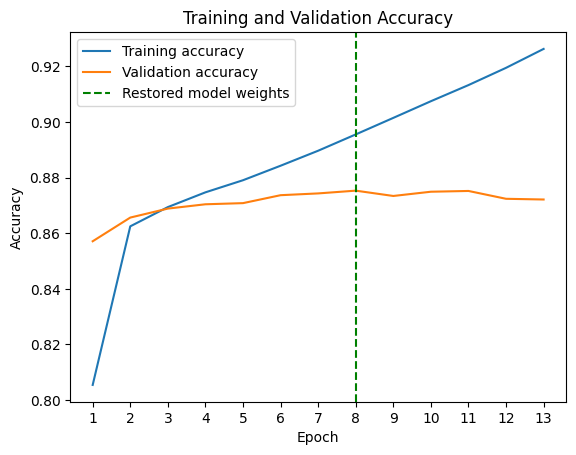

In [ ]:
plt.plot(
    history["accuracy"],
    label = "Training accuracy"
)

plt.plot(
    history["val_accuracy"],
    label = "Validation accuracy"
)

plt.axvline(
    best_epoch,
    label = 'Restored model weights',
    color = 'green',
    linestyle = '--'
)

plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.xticks(
    ticks = [i for i in range(len(history["accuracy"]))],
    labels = [i+1 for i in range(len(history["accuracy"]))]
)

plt.ylabel("Accuracy")
plt.legend()
plt.show()

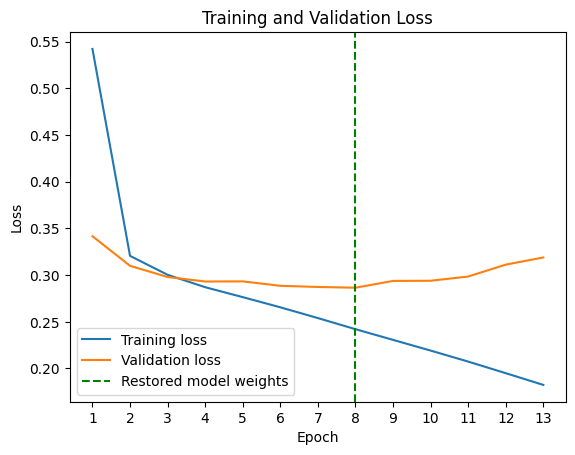

In [ ]:
plt.plot(
    history["loss"],
    label = "Training loss"
)

plt.plot(
    history["val_loss"],
    label = "Validation loss"
)

plt.axvline(
    best_epoch,
    label = 'Restored model weights',
    color = 'green',
    linestyle = '--'
)

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.xticks(
    ticks = [i for i in range(len(history["loss"]))],
    labels = [i+1 for i in range(len(history["loss"]))]
)

plt.ylabel("Loss")
plt.legend()
plt.show()

---

# Test

We get the accuracy of the predictions on test set:

In [ ]:
model.eval()
total_correct = 0
total_samples = 0
total_loss = 0.0
predictions = []
probabilities = []
labels = []

with torch.no_grad():
    for inputs, values in test_loader:
        labels.append(values.view(-1))

        outputs = model(inputs)

        loss = criterion(outputs, labels[-1])
        total_loss += loss.item()

        probabilities.append(torch.softmax(outputs, dim=1))
        predictions.append(torch.max(probabilities[-1], 1)[1])

        total_correct += (predictions[-1] == labels[-1]).sum().item()
        total_samples += labels[-1].size(0)

average_loss = total_loss / len(test_loader)
accuracy = total_correct / total_samples

labels = torch.cat(labels).cpu().numpy() + 1
predictions = torch.cat(predictions).cpu().numpy() + 1
probabilities = torch.cat(probabilities).cpu().numpy()

print(f">> Accuracy: {accuracy*100:.2f}%")
print(f">> Loss: {average_loss*100:.2f}%")

>> Accuracy: 87.24%
>> Loss: 31.88%


We plot probabilities from random predictions and actual ratings:

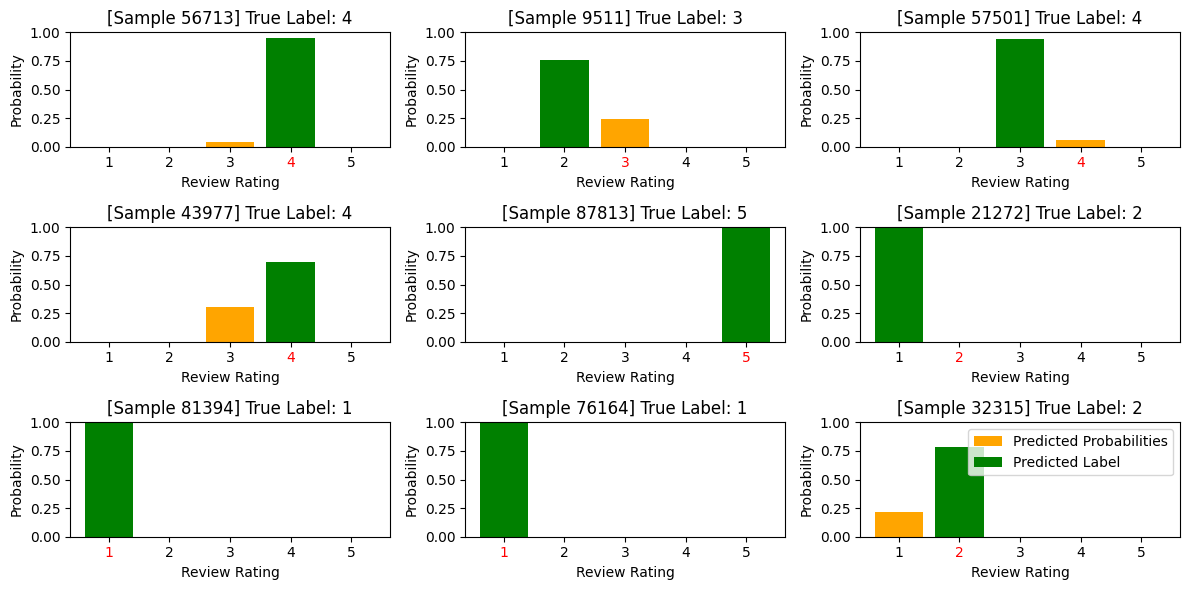

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 6))

for index in range(9):
    sample = np.random.randint(0, len(predictions))
    actual_rating = labels[sample]
    predicted_rating = predictions[sample]

    row = index // 3
    column = index % 3

    ax = axes[row, column]

    ax.bar(
        [1, 2, 3, 4, 5], probabilities[sample],
        label = 'Predicted Probabilities',
        color = 'orange'
    )

    ax.bar(
        predicted_rating, probabilities[sample][predicted_rating-1],
        color = 'green',
        label = 'Predicted Label'
    )

    ax.set_xlabel(f"Review Rating")
    ax.get_xticklabels()[actual_rating].set_color('red')
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 1)
    ax.set_title(f"[Sample {sample}] True Label: {actual_rating}")

plt.legend()
plt.tight_layout()
plt.show()

We compute and display the confusion matrix to see the misclassification errors rate:

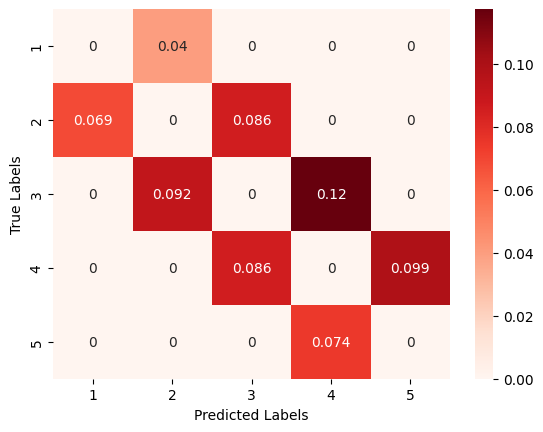

In [ ]:
normalized_confusion_matrix = confusion_matrix(
    y_true = list(labels),
    y_pred = list(predictions),
    normalize = 'true'
)

np.fill_diagonal(normalized_confusion_matrix, 0)

sns.heatmap(
    normalized_confusion_matrix,
    annot = True,
    cmap = "Reds",
    xticklabels = [1,2,3,4,5],
    yticklabels = [1,2,3,4,5]
)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

---

# Save and Load

Save the model in TorchScript Format:

In [ ]:
model_scripted = torch.jit.script(model)
model_scripted.save('data/model_scripted.pt')

Load the model:

In [ ]:
try:
    model = torch.jit.load('data/model_scripted.pt')
    print(f">> Model loaded!")
    model.eval()
except Exception as e:
    raise(e)

>> Model loaded!
